# Sentiment Analysis

In this series of notebooks we are building different machine learning models to detect sentiment (i.e. detect if a review is positive or negative) using Pytorch.

Sentiment analysis make sure that we are truly knowing to what our customers think, want and need.

Here are some benefits of sentiment analysis:
- Adjust marketing strategy: How we can know if we are doing the right thinks in e.g. social media etc.? The information in e.g. social media etc. provide us knowing what our customers feel and think about our brand.
- Measure ROI of your marketing campaign: Success of marketing campaign can lies in how positive discussions are amongst the customers.
- Develop a better product: Sentiment analysis helps us complete our market research by getting to know what our customers' opinions are about our product/services and how we can align our products/services quality and features with their tastes.
- Improve a better customer service: Sentiment analysis can pick up negative discussions, and give us real-time alerts so that we can respond quickly. Sentiment analysis as part of social listening to manage complaints can help us avoid leaving our customers feeling ignored and angry.
- Crisis management: Constant monitoring of what is currently happening in social media conversations also helps us to prevent or at least mitigate the damage of online communication crisis.


This will be done on Amazon reviews, using the ... dataset.
In this first notebook, we'll start very simple to understand the general concepts. Futher notebooks will build on this knowledge and we will actually get better results.

### Introduction

We will be using a recurrent neural network (RNN) as they are commonly used in analysing sequences. 

An RNN can be viewed as multiple feedforward neural networks, passing information from one to the other. If X={x_1, ...., x_t} a sequence of words then x_1,..,x_t represent our input words from the text, y_1,...,y_t represent the predicted next words and h_0,....,h_t hold the information for the previous input words. We use the RNN by feeding in the currend word x_t as well as the hidden state from the previous word, h_t-1, to produce the next hidden state, h_t.



Since plain text cannot be used in a neural network, because our machine learning models cannot operate on strings, only numbers, we need to encode the words into vectors. The mostly used approach is to use word embeddings (e.g. word2vec). In the first step, we will go for the one-hot-encoded vectors. These are vectors where all the values are 0, except the one at the i-th position. 

In [36]:
import pandas as pd
import numpy as np
import datapreprocessing as dp

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import re
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import PorterStemmer
from textblob import Word
from wordcloud import WordCloud

from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dimitriwilhelm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Collection and Review

Let's quickly start and read the file from the dataset in order to perform different tasks on it. We will use the Amazon reviews.

In [3]:
df_Apps = dp.getDF("Apps_for_Android_5.json")

Let's create a new dataframe with the columns 'reviewText' and 'sentiment'

In [45]:
# New column called 'sentiment'
df_Apps['sentiment'] = [1 if x > 3 else 0 for x in df_Apps['overall']]
# New DataFrame with columsn 'reviewText' and 'sentiment'
df_sentiment_data = df_Apps[['reviewText', 'sentiment']]

# Rename our columns
review_data = df_sentiment_data.reviewText
labels = df_sentiment_data.sentiment

In [ ]:
print(f'Minimum review length: {len(min(review_data, key=len))}')
print(f'Maximum review lenght: {len(max(review_data, key=len))}')

At first we will discuss different feature extraction methods, starting with some basic techniques and learn about preprocessing of the text data in order to extract better features from clean data, which will lead into further Natural Language Processing techniques at the end.

1. Feature extraction using text data
2. Data Preprocessing of text data
3. Further Textprocessing

## Feature extraction using text data

In [ ]:
def extract_data(data):
    """

    """
    data = pd.DataFrame(data)
    # Number of words in each review
    # Intuition: Negative sentiments conatin a lesser amout of words than the positive ones
    data['word_count'] = data['reviewText'].apply(lambda x: len(str(x).split(" ")))
    
    # Number of characters in each review
    data['char_count'] = data['reviewText'].str.len() ## this includes spaces too
    
    # Number of stopwords
    # While solving a NLP problem, the first thing we do is to remove the stopwords.
    data['numb_stopwords'] = data['reviewText'].apply(
        lambda x: len([x for x in x.split() if x in stop])
    )
    
    # Number of special characters
    
    
    # Number of numerics
    # It could be a useful feature that should be run
    data['numerics'] = data['reviewText'].apply(
        lambda x: len([x for x in x.split() if x.isdigit()])
    )
    
    # Number of Uppercase words
    # Anger or rage is quite often expressed by writing in UPPERCASE words
    data['uppercase'] = data['reviewText'].apply(
        lambda x: len([x for x in x.split() if x.isupper()])
    )
    
    # Check of empty reviews
    data['avg_word'] = data['reviewText'].apply(
        lambda x: sum( len(word) for word in (x.split()) )
    )
    idx = data[data.avg_word == 0].index
    data = data.drop(idx)
    
    # Average Word Length
    # We simply take the sum of the length of all the words and divide it by the total length of the review
    data['avg_word'] = data['reviewText'].apply(
        lambda x: sum( len(word) for word in (x.split())) / (len(x.split()) )
    )

In [ ]:
extract_data(review_data)

In [ ]:
# Let's check the first 5 rows
review_data.head()

Now we extract some features from text data. Before we diving into text and feature extraction, our next step will be clean the data in order to obtain better features. We achieve this by doing some of the preprocessing steps on our data.

## Data preprocessing of text data

All these data preprocessing steps are essential and will help us in reducing our vocabulary clutter so that the features produced in the end are more effective.

In [16]:
def clean_data(data):
    """

    """
    # Lower case
    # Transform our review into lower case. This avoids having multiple copies of the same words
    data['reviewText'] = data['reviewText'].apply(
        lambda x: " ".join( x.lower() for x in x.split() )
    )
    
    # Removing Punctuation, Numbers and Special Characters
    # It does not add any extra information while treating text data. Therefore it will help us reduce the size of the data
    data['reviewText'] = data['reviewText'].str.replace('[^a-zA-Z#]',' ')
    
    # Removal of Stop Words, i.e. we just removed commonly occurring words in a genearl sense
    # Stop Words should be removed from the text data. We use for this predefined libraries from nltk
    data['reviewText'] = data['reviewText'].apply(
        lambda x: " ".join( x for x in x.split() if x not in stop)
    )
    
    # Removing commonly occurring words from our text data
    # Let's check the 10 most frequently occuring words in our text data
    freq = pd.Series(" ".join( data['reviewText'] ).split()).value_counts()[:1]
    # Let's remove these words as their presence will not of any use in classification of our text data
    freq = list(freq.index)
    data['reviewText'] = data['reviewText'].apply(
        lambda x: " ".join( x for x in x.split() if x not in freq)
    )
    
    # Removal of rare words
    # Let's check the 10 rarely occurring words in our text data
    #freq_1 = pd.Series(" ".join( data['reviewText'] ).split()).value_counts()[:-1]
    # Let's remove these words as their presence will not of any use in classification of our text data
    #freq_1 = list(freq.index)
    #data['reviewText'] = data['reviewText'].apply(
    #    lambda x: " ".join(x for x in x.split() if x not in freq_1)
    #)
    
    # Stemming, i.e. we're removing suffices, like "ing", "ly", etc. by a simple rule-based approach.
    # For this purpose, we will use PorterStemmer from the NLTK library
    #st = PorterStemmer()
    #data['reviewText'] = data['reviewText'].apply(
    #    lambda x: " ".join([ st.stem(word) for word in x.split() ])
    #)
   
    # Lemmatization
    # Lemmatization is more effective that stemming because it converts the word into its root word, 
    # rather than just stripping the suffices. We usually prefer using lemmatiziation over stemming.
    data['reviewText'] = data['reviewText'].apply(
        lambda x: " ".join([ Word(word).lemmatize() for word in x.split() ])
    )
    
    # Revoming Short Words
    data['reviewText'] = data['reviewText'].apply(
        lambda x: " ".join([w for w in x.split() if len(w) > 3])
    )

In [47]:
data = pd.DataFrame(df_sentiment_data)

In [48]:
clean_data(data)

Now we have done all the preprocessing steps in order to clean our text data. Now, we can finally move on to extracting features using NLP techniques.

## Further Text Processing

### N-grams

# Exploring and  visualizing the reviews

In this section, we will explore the cleaned reviews.

Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

What are the most common words in the entire dataset?
What are the most common words in the dataset for negative and positive reviews, respectively?
How many  are there in a review?
Which trends are associated with my dataset?
Which trends are associated with either of the sentiments? Are they compatible with the sentiments?


### Understanding the common words in the dataset

Let's see how well the given sentiments are distributed across the review dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

Let’s visualize all the words our data using the wordcloud plot.

In [50]:
def total_words(data):
    return ' '.join([word for word in data['reviewText']])

def negative_sentiment_words(data):
    return ' '.join([text for text in data['reviewText'][data['sentiment'] == 0]])

def positive_sentiment_words(data):
    return ' '.join([text for text in data['reviewText'][data['sentiment'] == 1]])

In [52]:
all_words = total_words(data)
negative_words = negative_sentiment_words(data)
positive_words = positive_sentiment_words(data)

In [53]:
def plot_wordcloud(data):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(data)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

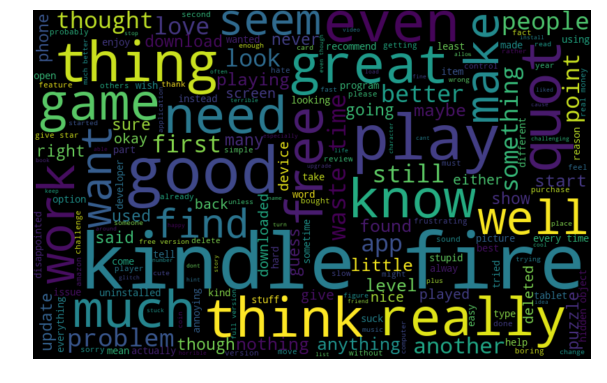

In [54]:
plot_wordcloud(negative_words)

In [ ]:
plot_wordcloud

Result: We can see most of the words are positive or neutral. Hence, we will plot separate wordclouds for both the classes(racist/sexist or not) in our train data.

In [38]:
negative_words = ' '.join([text for text in data['reviewText'][data['sentiment'] == 0]])

KeyError: 'sentiment'

In [ ]:
positive_words = ' '.join([text for text in data['reviewText'][combi['sentiment'] == 1]])

In [ ]:
#for i in range(len(sent_data[:10])):
#    list = sent_data.reviewText[:10].apply(lambda x: word_tokenize(x))

In [ ]:
sent_data['reviewText'] = sent_data.reviewText.apply(lambda x: x.lower())
#sent_data['reviewText'] = sent_data.reviewText.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ',x))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Prepare data
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

training_data = []
for i in range(len(review_data[:10])):
    training_data.append(
        (review_data[i].split(), [labels[i]])
    )
    
# First, we build an index of all tokens in the data.
token_index={}
for sample in review_data[:10]:
    #print(sample.split())
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index)
print(training_data)
#print(token_index)            

### Building an LSTM model for sentiment analysis

Pytorch’s LSTM expects all of its inputs to be 3D tensors. The semantics of the axes of these tensors is important. The three dimensions of this input are:

- Samples: One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps: One time step is one point of observation in the sample.
- Features: One feature is one observation at a time step.

This means that the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

When defining the input layer of your LSTM network, the network assumes you have 1 or more samples and requires that you specify the number of time steps and the number of features. You can do this by specifying a tuple to the “input_shape” argument.

We start building our model architecture in the code below.

Input: Our input is a sequence of words (technically, integer wordIDs) of maximum length = max_words
Output: Our Output is a binary sentiment label(0 or 1)

In [ ]:
# Create the model
class LSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # The linear layer that maps from hidden state space to label_size
        self.linear = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        # the first is the hidden h
        # the second is the cell  c
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embedded = self.word_embeddings(sentence)
        x = embedded.view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y  = self.linear(lstm_out[-1])
        log_probs = F.log_softmax(y)
        return log_probs

In [ ]:
def get_accuracy(truth, pred):
     assert len(truth)==len(pred)
     right = 0
     for i in range(len(truth)):
         if truth[i]==pred[i]:
             right += 1.0
     return right/len(truth)

In [ ]:
def train():
    # These will usually be more like 32 or 64 dimensional.
    # We will keep them small, so we can see how the weights change as we train.
    EMBEDDING_DIM = 6
    HIDDEN_DIM = 6
    INPUT_SIZE = len(token_index)
    OUTPUT_DIM = 2
    EPOCH = 20
    
    # Train the model
    model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, INPUT_SIZE, OUTPUT_DIM)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1e-3)
    
    # See what the scores are before training
    # Note that element i,j of the output is the score for tag j for word i.
    # Here we don't need to train, so the code is wrapped in torch.no_grad()
    #with torch.no_grad():
    #    inputs = prepare_sequence(training_data[1][0], token_index)
    #    sentiment_scores = model(inputs)

    for epoch in range(EPOCH):  # again, normally you would NOT do 300 epochs, it is toy data
        epoch_loss = 0
        count = 0
        for sentence, sentiment in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Also, we need to clear out the hidden state of the LSTM,
            # detaching it from its history on the last instance.
            model.hidden = model.init_hidden()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, token_index)

            targets = torch.tensor([1], dtype=torch.long)
            # Step 3. Run our forward pass.
            sentiment_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(sentiment_scores, targets)
            count += 1
            if count % 500 == 0:
                print(f'epoch: {epoch} iterations: {count} loss {loss.item()}')
            loss.backward()
            optimizer.step()
                   
            epoch_loss += loss.item()
            #print(epoch_loss)
        #print(f'{epoch_loss}')
        print(f'Epoche {epoch}: {epoch_loss / (len(training_data))}')
        
train()
# See what the scores are after training
#with torch.no_grad():
#    inputs = prepare_sequence(training_data[1][0], token_index)
#    sentiment_scores = model(inputs)
    #acc = get_accuracy(sentiment_scores, [1])
#    print(sentiment_scores)

### Word Embeddings

Word Embeddings are the texts converted into numbers and there may be different numerical representations of the same text. 

Why do we need Word Embeddings?

Many Machine Learning algorithms and almost all Deep Learning Architectures are incapable of processing strings or plain text in their raw text. They requires numbers as inputs to perform any sort of job.

A Word Embedding format generally tries to map a word using a dictionary to a vector.

Example sentence: "I love programming"

A word in this sentence may be "love" or "programming" etc.

A dictionary may be the list of all unique words in the sentence. So, a dictionary may look like - ["I", "love", "programming"]

A vector representation of a word may be a one-hot encoded vector where 1 stands for the position where the word exists and 0 everywhere else. The vector representation of "love" in this format according to the above dictionary is [0,1,0] and of "programming is [0,0,1].

This is a very simple method to represent a word in the vector form.

### Word2Vec

The idea behind Word2Vec is pretty simple. If you have two words that have very similar neighbors, i.e. the context in which its used is about the same, then then these words are probably quite similar in meaning or are at least related. For example, the words shocked, appalled and astonished are usually used in a similar context.

Using this underlying assumption, you can use Word2Vec to surface similar concepts, find unrelated concepts, compute similarity between two words and more!

### Training the Word2Vec model

Our parameters in order to train our model:
- size: The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me.
- window: The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window.
- min_count: Minimium frequency count of words. The model would ignore words that do not statisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.
- workers: How many threads to use behind the scenes?

In [ ]:
#sent_data.reviewText[:10][0].split()

In [ ]:
review_list = []
for i in range(len(sent_data[:10])):
    #list1 = sent_data.reviewText[:10].apply(lambda x: word_tokenize(x))
    review_list.append(sent_data.reviewText[:10][i].split())

In [ ]:
# train model
model = Word2Vec(review_list, size=50, min_count=1, window=5, workers=5)
model.train(review_list, total_examples=len(review_list), epochs=10)

# summarize the loaded model
print(model)

# summarize vocabulary
words = model.wv.vocab
print(words)

In [ ]:
#model[model.wv.vocab]

In [ ]:
# save model
model.save('model.bin')

# load model
new_model = Word2Vec.load('model.bin')
#print (new_model)

# That looks pretty good, right? Let's look at a few more. Let's look at similarity for polite, france and shocked.

In [ ]:
# access vector for one word
w1 = 'loves'
print(model.wv.most_similar(positive=w1, topn=2))
model.wv['loves'].tolist()[0]

In [ ]:
# Prepare data
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

training_data = []
for i in range(len(review_data[:10])):
    training_data.append(
        (review_data[i].split(), [labels[i]])
    )
    
# First, we build an index of all tokens in the data for our Word2Vec.
token_index={}
for sample in review_data[:10]:
    for word in sample.split():
        if word in model.wv:
            token_index[word] = model.wv[word]

print(token_index)

In [ ]:
# Create the model
class LSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        #self.size = size
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # The linear layer that maps from hidden state space to label_size
        self.linear = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        # the first is the hidden h
        # the second is the cell  c
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embedded = self.word_embeddings(sentence)
        x = embedded.view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y  = self.linear(lstm_out[-1])
        log_probs = F.log_softmax(y)
        return log_probs

In [ ]:
# Train Fuck for Word2Vec
def train():
    # These will usually be more like 32 or 64 dimensional.
    # We will keep them small, so we can see how the weights change as we train.
    EMBEDDING_DIM = 6
    HIDDEN_DIM = 6
    INPUT_SIZE = len(token_index)
    OUTPUT_DIM = 2
    EPOCH = 20
    SIZE = 50
    
    # Train the model
    model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, INPUT_SIZE, OUTPUT_DIM)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1e-3)
    
    # See what the scores are before training
    # Note that element i,j of the output is the score for tag j for word i.
    # Here we don't need to train, so the code is wrapped in torch.no_grad()
    #with torch.no_grad():
    #    inputs = prepare_sequence(training_data[1][0], token_index)
    #    sentiment_scores = model(inputs)

    for epoch in range(EPOCH):  # again, normally you would NOT do 300 epochs, it is toy data
        epoch_loss = 0
        count = 0
        for sentence, sentiment in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Also, we need to clear out the hidden state of the LSTM,
            # detaching it from its history on the last instance.
            model.hidden = model.init_hidden()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, token_index)
            targets = torch.tensor([1], dtype=torch.long)
            # Step 3. Run our forward pass.
            sentiment_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(sentiment_scores, targets)
            count += 1
            if count % 500 == 0:
                print(f'epoch: {epoch} iterations: {count} loss {loss.item()}')
            loss.backward()
            optimizer.step()
                   
            epoch_loss += loss.item()
            #print(epoch_loss)
        #print(f'{epoch_loss}')
        print(f'{epoch}: {epoch_loss / (len(training_data))}')

train()
# See what the scores are after training
#with torch.no_grad():
#    inputs = prepare_sequence(training_data[1][0], token_index)
#    sentiment_scores = model(inputs)
    #acc = get_accuracy(sentiment_scores, [1])
#    print(sentiment_scores)

Problems with a standard RNN

The simplest RNN model has a major drawback, called vanishing gradient problem, which prevents it from being accurate. The problem comes from the fact that at each time step during training we are using the same weights to calculate y_t. That multiplication is also done during backpropagation. The further we move backwards, the bigger or smaller our error signal becommes. This means that the network experiences difficulty in memorizing words from far away in the sequence and makes predictions based onv only the most recent ones.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

values = np.array(tokens)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder()
integer_encoded = integer_encoded.reshape(-1, 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)
#print(integer_encoded)

In [ ]:
max_words = 10
results = np.zeros((len(review_data[:10]), max_words, max(token_index.values()) + 1))
for i, sample in enumerate(review_data[:10]):
    for j, word in list(enumerate(sample.split()))[:max_words]:
        index = token_index.get(word)
        results[i,j,index] = 1
results

In order to feed this data into our RNN, all input documents must have the same length. We will accomplish

Our RNN class is a sub-class of nn.Module and the use of super.

Within the __init__ we define three layers
 - embedding layer: The embedding layer is used to transform our sparse one-hot vector (sparse as most of the elements are 0) into a dense embedding vector (dense as the dimensionality is a lot smaller and all the elements are real numbers). This embedding layer is simply a single fully connected layer.
 - RNN: The RNN layer takes in our dense vector and the previous hidden state h_t-1, which it uses to calculate the next hidden state, h_t.
 - linear layer: The linear layer takes the final hidden state and feeds it through a fully connected layer, f(h_T), transforming it to the correct output size.

The forward method is called when we feed examples into our model.

- Each batch, x, is a tensor of size [sentence_length, batch_size]. That is a batch of sentences, each having each word converted into a one-hot-vector. This tensor representing a sentence is just a tensor of the indexes for each token in that sentence.

- The input batch is than passed through the embedding layer to get embedded, which gives us a dense vector representation of our sentences. embedded is a tensor of size [sentence_length, batch_size, embedding_size].

- embedded is then fed into the RNN. Note: in PyTorch if no initial hidden state is passed as an argument it defaults to a tensor of all zeros.

- The RNN returns two tensors, output of size [sentence_length, batch_size, hidden_size] and hidden of size [1, batch_size, embedding_size]. 



In [ ]:
#token_list = list(token_index)
#values = np.array(token_list)

# integer encode
#label_encoder = LabelEncoder()
#label_encoder.fit(values)


#for i in range(len(review_data[:10])):
#    split_review = word_tokenize(review_data[i])
#    #print(split_review)
#    results = label_encoder.transform(split_review)
#    results = list(np.array(results))
    
#print(results)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class RNN(nn.Module):
    def __init__(self, batch_size, input_size, embedding_size, hidden_size, output_size):
        super().__init__()
        
        """

        """
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, output_size)

    def forward(self, sentence):
        # hidden size h_0
        h_0 = (torch.zeros(1, self.batch_size, self.hidden_size))
        
        embedded = self.embedding(sentence)
        x = embedded.view(len(sentence), self.batch_size, -1)
        rnn_ouput, self.hidden = self.rnn(x, h_0)
        predict = self.out(rnn_output)
        

In [ ]:
BATCH_SIZE = 64
INPUT_SIZE = len(token_index)
EMBEDDING_SIZE = 100
HIDDEN_SIZE = 256
OUTPUT_DIM = 1

model = RNN(BATCH_SIZE, INPUT_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, OUTPUT_DIM)
model

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
def binary_accuarcy(pred, y_pred):
    rounded_pred = torch.round(torch.sig(preds))
    correct = (rounded_pred == y_pred).float()
    acc = correct.sum()/len(correct)
    return acc

In [ ]:
def train(model, labels, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    token_list = list(token_index)
    values = np.array(token_list)

    # integer encode
    label_encoder = LabelEncoder()
    label_encoder.fit(values)


    for i in range(len(review_data[:10])):
        split_review = word_tokenize(review_data[i])
        #print(split_review)
        sequence = label_encoder.transform(split_review)
        sequence, label = (np.array(results), labels)
        optimizer.zero_grad()
        sequence = torch.LongTensor(sequence.astype('int32'))
        predictions = model(sequence)
        label = torch.LongTensor(label.astype('int64'))
        print(label)
        print(predictions)
        loss = criterion(predictions, label.unsqueeze(1)[i])
        
        #acc = binary_accuarcy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        #epoch_acc += acc.item()
        print(epoch_loss)
        
    return epoch_loss / len(results), epoch_acc / len(results)